In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
import nltk
import datetime
import time
import os
%matplotlib inline
import string

In [2]:
BASE_DIR = ''
GLOVE_DIR = BASE_DIR + '/Users/shashankbhushan/Downloads/glove.6B'
FACEBOOK_DATASET = '/Users/shashankbhushan/Downloads/wiki.en.vec'
DATA_SET_DIR = '../DataGrabber/data/txt/'
TOP_N_WORDS = 40
EMBEDDING_DIM = 300
lemmatizer = nltk.stem.WordNetLemmatizer()
#Function to preprocess the data to remove unwanted characters
def preprocess(description):
    # only processing if the the value is a string
    if type(description)!=type(2.0):
        #Decoding to remove encoding issues
        description = description.decode('latin-1').encode("utf-8").decode('utf-8').strip()
        description = description.lower()
        # Removing hashtags and other characters
        description = " ".join(description.split('*'))
        description = " ".join(description.split('#'))
        # Removing URLs
        description = re.sub('((www\.[^\s]+)|(https://[^\s]+))','',description)
        description = re.sub('((pic\.[^\s]+)|(https://[^\s]+))','',description)
        description = re.sub("(http\S+)|(https\S+)", '', description)
        #
        description = description.strip('\'"').strip()
        description = " ".join([lemmatizer.lemmatize(word) for word in description.split(" ")])
    return description
# this will process the whole text data line by line
def processingDocument(textData):
    lines = textData.split('\n')
    #processing, rejoining the lines and returning it
    return ' '.join(map(preprocess, lines))

In [3]:
print('Indexing word vectors.')

#Using Glove word embedding for the time being
embeddings_index = {}
#f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
f = open(FACEBOOK_DATASET)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 2519371 word vectors.


In [3]:
#getting only the directories in the folder
directories = filter(lambda x: os.path.isdir(os.path.join(DATA_SET_DIR, x)), os.listdir(DATA_SET_DIR))
dataSet = {}
#reading data from all the folders
for direc in directories:
    texts = []  # list of text samples
    files = os.listdir(os.path.join(DATA_SET_DIR, direc))
    for name in files:
        path = os.path.join(DATA_SET_DIR, direc, name)
        f = open(path)
        texts.append(f.read())
        f.close()
    dataSet[direc] = texts

## Experiment:

### Things that I tried
1. Does using tf-idf vectorizer trained on samples belonging to the same category lead to a better result than one trained on all the datasets - The one trained in all the documents provide a better result
2. How to represent phrases that are not present in the pre-trained model. This is still not completly solved as training for out-of-vocabulary words seems to be the only option. For now the embeddings for the terms in the phrase are added along with the embedding for "Computer Science". This was tested to give a higher cosine similarity. Look at "Testing for cosine similarity using algebraic operations" for the results
3. Tried representing the documents using:
        a. Average of the word embeddings(the word vector representation) of the top 40 pharases as per TF-IDF score
        b. Weighted Average of the word embeddings(the word vector representation) of the top 40 pharases as per TF-IDF score. The TF-IDF score was taken as the weight
4. For each of the document representation reduced the dimension using SVD and T-SNE and plotted them on a scatter plot to understand if papers belonging to one topic form a cluster or not

In [4]:
#performing the same for all the data available
cleanedData_all = []
labels = []
for key in dataSet.keys():
    cleanedData_all.extend(map(processingDocument, dataSet[key]))
    labels.extend([key for x in xrange(len(dataSet[key]))])

In [5]:
# TF-IDF vectorizer, the token pattern ensures that only terms of length > 1 are considered
v_all = TfidfVectorizer(input='content', 
        encoding='utf-8', decode_error='replace', strip_accents='unicode', 
        lowercase=True, analyzer='word', stop_words='english', 
        token_pattern=r'(?u)\b[a-zA-Z_][a-zA-Z0-9_]+\b',
        ngram_range=(1, 2), max_features = 10000) 

v_all.fit(cleanedData_all)

TfidfVectorizer(analyzer='word', binary=False, decode_error='replace',
        dtype=<type 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b[a-zA-Z_][a-zA-Z0-9_]+\\b', tokenizer=None,
        use_idf=True, vocabulary=None)

In [6]:
#Time to choose a research paper for the experiment
testFileName = '/Users/shashankbhushan/Documents/Github/cse579/DataGrabber/data/txt/cs.LG/1509.06163v1.pdf.txt'
testData = cleanedData_all[15]
transformed_all = v_all.transform([testData])

In [7]:
featureNames = np.array(v_all.get_feature_names())
Sortedindices = np.array(np.argsort(transformed_all.todense()))[0].flatten()[::-1]
ImportantTerms = featureNames[Sortedindices[:TOP_N_WORDS]]
ImportantTerms

array([u'native', u'eigenspace', u'syllable', u'pca', u'word',
       u'nn classii', u'nn', u'speaker', u'detection', u'face',
       u'test sample', u'class', u'wia', u'sample', u'cation',
       u'threshold', u'classii', u'class data', u'classii cation', u'test',
       u'spectrogram', u'target word', u'training', u'step',
       u'verii cation', u'face recognition', u'data', u'verii', u'dii',
       u'e1', u'e2', u'language', u'numerical', u'recognition', u'testing',
       u'distribution', u'used', u'td', u'pe', u'figure'], 
      dtype='<U27')

In [49]:
#Time to represent each of the document by its embedded representation
cs = embeddings_index['computer_science']
empty = np.zeros(EMBEDDING_DIM)
def getWordEmbeddings(word, isComputerScience = True):
    #If the phrase is not present is a problem we have to solve
    # Current default strategy try for sum of individual words and the term for cs
    terms = word.split(' ')
    if len(terms) > 1:
        rep1 = ''.join(terms)
        rep2 = '_'.join(terms)
        if rep1 in embeddings_index:
            return embeddings_index[rep1]
        elif rep2 in embeddings_index:
            return embeddings_index[rep2]
        else:
            # No appropriate embedding found
            errorFile.write('No appropriate embedding found for: ' + word + '\n')
            return reduce(lambda x,y: x+y, map(lambda x: embeddings_index.get(x, empty), terms)) + cs if isComputerScience else empty
    else:
        #Defaulting to empty vector in case the term is not present
        #TODO: Code is sort of failing here silently and never raises an issue probably should log this
        return embeddings_index.get(word, empty)
    
def getDocRepresentation(vectorizer, featureNames, document, weighted=False, impFeatures = TOP_N_WORDS):
    transformedText = vectorizer.transform([document])
    Sortedindices = np.array(np.argsort(transformedText.todense()))[0].flatten()[::-1][:impFeatures]
    ImportantTerms = featureNames[Sortedindices]
    if not weighted:
        #returing the average of all word embeddings
        return reduce(lambda x, y: x + y, map(getWordEmbeddings, ImportantTerms))/impFeatures
    else:
        wordEmbeddings = map(getWordEmbeddings, ImportantTerms)
        weights = list(np.array(transformedText.todense())[0][Sortedindices])
        weightedSum = np.zeros(EMBEDDING_DIM)
        for i, embed in enumerate(wordEmbeddings):
            weightedSum += weights[i]*embed
        #returning the weighted average
        return weightedSum/impFeatures

In [28]:
featureNames = np.array(v_all.get_feature_names())
errorFile = open('unknownEmbeddings.txt', 'w')
docRepresentation = map(lambda x: getDocRepresentation(v_all, featureNames, x), cleanedData_all)
errorFile.close()

## Testing for cosine similarity using algebraic operations

In [36]:
A = embeddings_index['artificial']
I = embeddings_index['intelligence']
M = embeddings_index['mining']
D = embeddings_index['data']
AI = embeddings_index['artificial_intelligence']
DM = embeddings_index['data_mining']
from sklearn.metrics.pairwise import cosine_similarity
print cosine_similarity(AI, A+I+cs)
print cosine_similarity(DM, M+D+cs)

[[ 0.7435137]]
[[ 0.63754719]]


/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1,

## T-SNE Decomposition 
So that we can visualize the data in a scatter plot

In [38]:
from sklearn.decomposition import TruncatedSVD
#Reducing the dimension to 50 as per advice found in online forumns
docRepresentation_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(docRepresentation)

In [43]:
from sklearn.manifold import TSNE
docEmbedded = TSNE(n_components=2, perplexity=40, verbose=2, method='exact').fit_transform(docRepresentation_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 704 / 704
[t-SNE] Mean sigma: 0.326330
[t-SNE] Iteration 25: error = 17.7131027, gradient norm = 0.0844612
[t-SNE] Iteration 50: error = 18.0672229, gradient norm = 0.0766623
[t-SNE] Iteration 75: error = 17.7151517, gradient norm = 0.0797360
[t-SNE] Iteration 100: error = 17.5324940, gradient norm = 0.0739562
[t-SNE] KL divergence after 100 iterations with early exaggeration: 17.532494
[t-SNE] Iteration 125: error = 1.2893932, gradient norm = 0.0083837
[t-SNE] Iteration 150: error = 1.2747084, gradient norm = 0.0099627
[t-SNE] Iteration 175: error = 1.2911963, gradient norm = 0.0095461
[t-SNE] Iteration 200: error = 1.3073621, gradient norm = 0.0102016
[t-SNE] Iteration 225: error = 1.3204352, gradient norm = 0.0099257
[t-SNE] Iteration 225: did not make any progress during the last 50 episodes. Finished.
[t-SNE] Error after 225 iterations: 17.532494


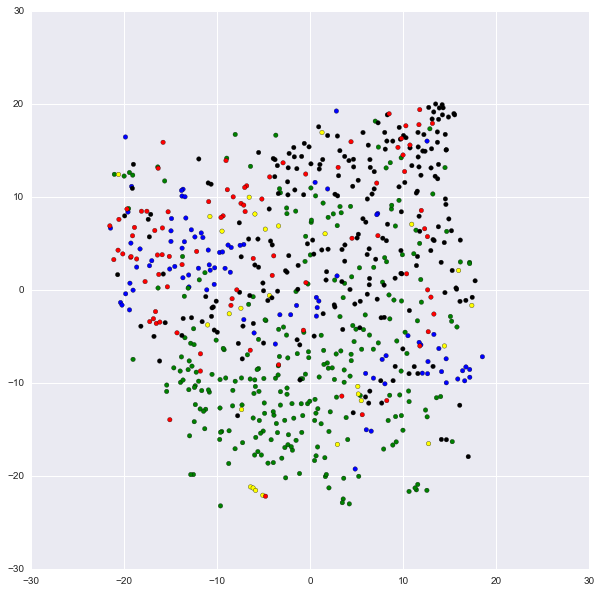

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = {'cs.AI': 'red', 'cs.CL': 'blue', 'cs.CV': 'green', 'cs.LG': 'black', 'cs.NE': 'yellow'}
ax.scatter(docEmbedded[:, 0], docEmbedded[:, 1],
        c=map(lambda x: colors[x], labels))
plt.show()

The field of computer vision has its own nice cluster for others the boundary is not that clear
Lets try with weighted n-grams to check if it gives any better result

In [53]:
#Now trying weighted measure
featureNames = np.array(v_all.get_feature_names())
errorFile = open('unknownEmbeddings.txt', 'w')
docRepresentation_weighted = map(lambda x: getDocRepresentation(v_all, featureNames, x, True), cleanedData_all)
errorFile.close()

In [54]:
#Reducing the dimension to 50 as per advice found in online forumns
docRepresentation_weighted_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(docRepresentation_weighted)
#T-SNE reduction
docEmbedded_weighted = TSNE(n_components=2, perplexity=40, verbose=2, method='exact').fit_transform(docRepresentation_weighted_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 704 / 704
[t-SNE] Mean sigma: 0.045826
[t-SNE] Iteration 25: error = 17.7814664, gradient norm = 0.0833914
[t-SNE] Iteration 50: error = 17.4165062, gradient norm = 0.0780545
[t-SNE] Iteration 75: error = 17.6178698, gradient norm = 0.0783457
[t-SNE] Iteration 100: error = 17.4252834, gradient norm = 0.0725644
[t-SNE] KL divergence after 100 iterations with early exaggeration: 17.425283
[t-SNE] Iteration 125: error = 1.1891867, gradient norm = 0.0087047
[t-SNE] Iteration 150: error = 1.1941384, gradient norm = 0.0101631
[t-SNE] Iteration 175: error = 1.1984851, gradient norm = 0.0101370
[t-SNE] Iteration 200: error = 1.2028436, gradient norm = 0.0109879
[t-SNE] Iteration 200: did not make any progress during the last 50 episodes. Finished.
[t-SNE] Error after 200 iterations: 17.425283


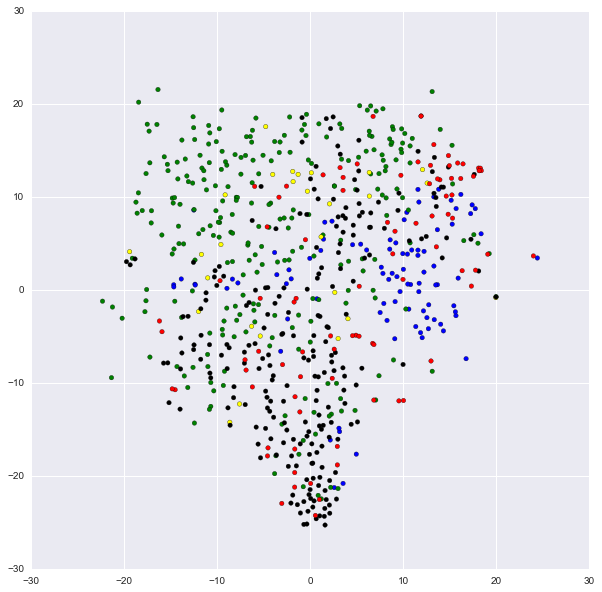

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))
colors = {'cs.AI': 'red', 'cs.CL': 'blue', 'cs.CV': 'green', 'cs.LG': 'black', 'cs.NE': 'yellow'}
ax.scatter(docEmbedded_weighted[:, 0], docEmbedded_weighted[:, 1],
        c=map(lambda x: colors[x], labels))
plt.show()

The results are similar to what was observed for normal average weighting. Probably a bigger dataset will allow for better understanding.
Also it would be worth checking how much overlap is observed for a completely different field like "Physics"

## Analysis using cluster similarity
- Keywords in the query = Image processing, Computer Vision, Neural Network
- Paper = 'Pixel recurrent neural networks'

In [6]:
testFile = open('PixelRecurrentNeuralNetworks.txt','r')
testData = map(processingDocument, [' '.join(testFile.readlines())])[0]

transformed = v_all.transform([testData])

In [7]:
featureNames = np.array(v_all.get_feature_names())
Sortedindices = np.array(np.argsort(transformed.todense()))[0].flatten()[::-1]
ImportantTerms = featureNames[Sortedindices[:TOP_N_WORDS]]
ImportantTerms

array([u'pixel', u'lstm', u'bilstm', u'layer', u'cifar', u'image',
       u'model', u'row', u'mask', u'imagenet', u'recurrent', u'diagonal',
       u'convolution', u'residual', u'state', u'network',
       u'recurrent neural', u'neural', u'distribution', u'mnist', u'map',
       u'discrete', u'input', u'lstm layer', u'log likelihood',
       u'connection', u'xi', u'figure', u'murray', u'et al', u'et',
       u'conditional', u'value', u'generative', u'multi scale', u'al',
       u'pixel value', u'receptive eld', u'likelihood', u'neural network'], 
      dtype='<U27')

In [75]:
keywords = ['image processing', 'computer vision', 'neural network']
errorFile = open('unknownEmbeddings_test.txt', 'w')
documentRepresentationCluster = map(getWordEmbeddings, ImportantTerms)
keywordCluster = map(getWordEmbeddings, keywords)
errorFile.close()

In [76]:
from sklearn.metrics import silhouette_score
labels_cluster = [0 for x in xrange(TOP_N_WORDS)]
labels_cluster.extend(1 for x in xrange(len(keywords)))
X = list(documentRepresentationCluster)
X.extend(keywordCluster)
silhouette_score(X, labels_cluster)

0.084432831010783013

In [82]:
testFile_control1 = open('1604.04835v2.pdf.txt','r') #About Knowledge Graph Embedding with Text Descriptions talks about neural network 
testFile_control2 = open('1402.0779v3.pdf.txt','r') #About machine learning optimization
testFile_control3 = open('1702.08628v1.pdf.txt', 'r') #About Value of information, constrained search, reinforcement learning, information theory

testData_control = [map(processingDocument, [' '.join(testFile_control1.readlines())])[0]]
testData_control.append(map(processingDocument, [' '.join(testFile_control2.readlines())])[0])
testData_control.append(map(processingDocument, [' '.join(testFile_control3.readlines())])[0])

transformed_control = v_all.transform(testData_control)

In [78]:
#For Control 1 #About Knowledge Graph Embedding with Text Descriptions talks about neural network 
Sortedindices = np.array(np.argsort(transformed_control[0].todense()))[0].flatten()[::-1]
ImportantTerms = featureNames[Sortedindices[:TOP_N_WORDS]]

errorFile = open('unknownEmbeddings_test.txt', 'w')
documentRepresentationCluster_control_1 = map(getWordEmbeddings, ImportantTerms)

ImportantTerms

array([u'ssp', u'triple', u'transe', u'knowledge graph', u'entity',
       u'textual', u'embedding', u'semantic', u'hyperplane', u'knowledge',
       u'graph', u'et al', u'et', u'semantics', u'al', u'model', u'topic',
       u'descriptions', u'rank', u'loss', u'vector', u'symbolic', u'std',
       u'mean rank', u'head', u'em bedding', u'bordes', u'bedding',
       u'tail', u'completion', u'description', u'relevance', u'cid',
       u'joint', u'precise', u'text', u'sh', u'nmf', u'wang', u'specii'], 
      dtype='<U27')

In [79]:
X = list(documentRepresentationCluster_control_1)
X.extend(keywordCluster)
print 'For Control 1:', silhouette_score(X, labels_cluster)

For Control 1: 0.130738990396


In [80]:
#For Control 2  #About machine learning optimization
Sortedindices = np.array(np.argsort(transformed_control[1].todense()))[0].flatten()[::-1]
ImportantTerms = featureNames[Sortedindices[:TOP_N_WORDS]]

documentRepresentationCluster_control_2 = map(getWordEmbeddings, ImportantTerms)

ImportantTerms

array([u'proximal', u'solver', u'operator', u'function', u'prox',
       u'differentiable', u'f1', u'f2', u'f3', u'splitting', u'norm',
       u'problem', u'toolbox', u'param', u'eval', u'objective function',
       u'forward backward', u'arg min', u'matlab', u'solving problem',
       u'convex', u'backward', u'solving', u'objective', u'gradient',
       u'arg', u'xi', u'optimization', u'iteration', u'solution',
       u'forward', u'dei', u'rn', u'xa', u'xia', u'step size', u'min',
       u'f1 f2', u'step', u'gamma'], 
      dtype='<U27')

In [81]:
X = list(documentRepresentationCluster_control_2)
X.extend(keywordCluster)
print 'For Control 2:', silhouette_score(X, labels_cluster)

For Control 2: 0.0844328310108


In [83]:
#For Control 3 #About Value of information, constrained search, reinforcement learning, information theory
Sortedindices = np.array(np.argsort(transformed_control[2].todense()))[0].flatten()[::-1]
ImportantTerms = featureNames[Sortedindices[:TOP_N_WORDS]]

documentRepresentationCluster_control_3 = map(getWordEmbeddings, ImportantTerms)

ImportantTerms

array([u'step cost', u'st', u'cost step', u'pac', u'st st', u'cost', u'ae',
       u'step', u'pr', u'man', u'respectively', u'apr', u'anda', u'blue',
       u'thei', u'ata', u'moderate', u'green', u'orange', u'cambridge ma',
       u'red', u'ini', u'sta', u'sa', u'ups', u'usa', u'max',
       u'eventually', u'lastly', u'cambridge', u'fruit', u'oi', u'eds',
       u'pp', u'guration', u'aa', u'ms', u'plot', u'lee', u'information'], 
      dtype='<U27')

In [84]:
X = list(documentRepresentationCluster_control_3)
X.extend(keywordCluster)
print 'For Control 3:', silhouette_score(X, labels_cluster)

For Control 3: 0.152482029867


In [31]:
from nltk.corpus import wordnet as wn

expandedTerms = []
normalTerms = []
for term in ImportantTerms:
    t = wn.synsets(term)
    if not t:
        normalTerms.append(term)
    else:
        expandedTerms.extend(wn.synsets(term))

filteredTerms = filter(lambda x: str(x).split("'")[1].split('.')[1] == 'n', expandedTerms)

In [35]:
filteredTerms = map(lambda x: str(x).split("'")[1], filteredTerms)
filteredTerms.extend(normalTerms)

In [36]:
filteredTerms

['pixel.n.01',
 'layer.n.01',
 'layer.n.02',
 'level.n.07',
 'layer.n.04',
 'layer.n.05',
 'image.n.01',
 'persona.n.02',
 'picture.n.01',
 'prototype.n.01',
 'trope.n.01',
 'double.n.03',
 'image.n.07',
 'image.n.08',
 'effigy.n.01',
 'model.n.01',
 'model.n.02',
 'model.n.03',
 'model.n.04',
 'exemplar.n.01',
 'model.n.06',
 'model.n.07',
 'mannequin.n.01',
 'model.n.09',
 'row.n.01',
 'quarrel.n.01',
 'row.n.03',
 'course.n.08',
 'row.n.05',
 'row.n.06',
 'rowing.n.01',
 'mask.n.01',
 'mask.n.02',
 'masquerade.n.01',
 'mask.n.04',
 'diagonal.n.01',
 'diagonal.n.02',
 'diagonal.n.03',
 'diagonal.n.04',
 'solidus.n.02',
 'whirl.n.02',
 'gyrus.n.01',
 'convolution.n.03',
 'remainder.n.01',
 'residual.n.02',
 'state.n.01',
 'state.n.02',
 'state.n.03',
 'state.n.04',
 'state_of_matter.n.01',
 'state.n.06',
 'country.n.02',
 'department_of_state.n.01',
 'network.n.01',
 'network.n.02',
 'net.n.06',
 'network.n.04',
 'network.n.05',
 'distribution.n.01',
 'distribution.n.02',
 'distributi

In [42]:
fil = open('/Users/shashankbhushan/Documents/paper1.db', 'w')
for t in filteredTerms:
    fil.write('HasWord(' + t + ', 1)' + '\n')
fil.close()

In [40]:
keywords = ['image', 'convolution', 'neural network']
for key in keywords:
    print wn.synsets(key)

[Synset('image.n.01'), Synset('persona.n.02'), Synset('picture.n.01'), Synset('prototype.n.01'), Synset('trope.n.01'), Synset('double.n.03'), Synset('image.n.07'), Synset('image.n.08'), Synset('effigy.n.01'), Synset('image.v.01'), Synset('visualize.v.01')]
[Synset('whirl.n.02'), Synset('gyrus.n.01'), Synset('convolution.n.03')]
[]
